In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels
import scikit_posthocs as sp
import sys
import scipy


In [12]:
#monkey patching violion plot

import matplotlib as mpl
import warnings
from seaborn.categorical import _CategoricalPlotter
from seaborn.utils import (
    desaturate,
    _check_argument,
    _draw_figure,
    _default_color,
    _get_patch_legend_artist,
    _get_transform_functions,
    _scatter_legend_artist,
    _version_predates,
)
from seaborn._core.typing import default, deprecated
from seaborn._stats.density import KDE
class MyCategoricalPlotter(_CategoricalPlotter):

    def plot_violins(
        self,
        width,
        dodge,
        gap,
        split,
        color,
        fill,
        linecolor,
        linewidth,
        inner,
        density_norm,
        common_norm,
        kde_kws,
        inner_kws,
        plot_kws,
    ):
        iter_vars = [self.orient, "hue"]
        value_var = {"x": "y", "y": "x"}[self.orient]

        inner_options = ["box","line_quart", "quart", "stick", "point", None]
        _check_argument("inner", inner_options, inner, prefix=True)
        _check_argument("density_norm", ["area", "density", "width"], density_norm)

        if linewidth is None:
            if fill:
                linewidth = 1.25 * mpl.rcParams["patch.linewidth"]
            else:
                linewidth = mpl.rcParams["lines.linewidth"]

        if inner is not None and inner.startswith("box"):
            box_width = inner_kws.pop("box_width", linewidth * 4.5)
            whis_width = inner_kws.pop("whis_width", box_width / 3)
            marker = inner_kws.pop("marker", "_" if self.orient == "x" else "|")

        kde = KDE(**kde_kws)
        ax = self.ax
        violin_data = []

        # Iterate through all the data splits once to compute the KDEs
        for sub_vars, sub_data in self.iter_data(iter_vars,
                                                 from_comp_data=True,
                                                 allow_empty=False):

            sub_data["weight"] = sub_data.get("weights", 1)
            stat_data = kde._transform(sub_data, value_var, [])

            maincolor = self._hue_map(sub_vars["hue"]) if "hue" in sub_vars else color
            if not fill:
                linecolor = maincolor
                maincolor = "none"
            default_kws = dict(
                facecolor=maincolor,
                edgecolor=linecolor,
                linewidth=linewidth,
            )

            violin_data.append({
                "position": sub_vars[self.orient],
                "observations": sub_data[value_var],
                "density": stat_data["density"],
                "support": stat_data[value_var],
                "kwargs": {**default_kws, **plot_kws},
                "sub_vars": sub_vars,
                "ax": self._get_axes(sub_vars),
            })

        # Once we've computed all the KDEs, get statistics for normalization
        def vars_to_key(sub_vars):
            return tuple((k, v) for k, v in sub_vars.items() if k != self.orient)

        norm_keys = [vars_to_key(violin["sub_vars"]) for violin in violin_data]
        if common_norm:
            common_max_density = np.nanmax([v["density"].max() for v in violin_data])
            common_max_density = np.nanmax([len(v["observations"]) for v in violin_data])
            max_density = {key: common_max_density for key in norm_keys}
            max_density = {key: common_max_density for key in norm_keys}
        else:
            with warnings.catch_warnings():
                # Ignore warning when all violins are singular; it's not important
                warnings.filterwarnings('ignore', "All-NaN (slice|axis) endensityered")
                max_density = {
                    key: np.nanmax([
                        v["density"].max() for v in violin_data
                        if vars_to_key(v["sub_vars"]) == key
                    ]) for key in norm_keys
                }
            max_density = {
                key: np.nanmax([
                    len(v["observations"]) for v in violin_data
                    if vars_to_key(v["sub_vars"]) == key
                ]) for key in norm_keys
            }

        real_width = width * self._native_width

        # Now iterate through the violins again to apply the normalization and plot
        for violin in violin_data:

            index = pd.RangeIndex(0, max(len(violin["support"]), 1))
            data = pd.DataFrame({
                self.orient: violin["position"],
                value_var: violin["support"],
                "density": violin["density"],
                "width": real_width,
            }, index=index)

            if dodge:
                self._dodge(violin["sub_vars"], data)
            if gap:
                data["width"] *= 1 - gap

            # Normalize the density across the distribution(s) and relative to the width
            norm_key = vars_to_key(violin["sub_vars"])
            hw = data["width"] / 2
            peak_density = violin["density"].max()
            if np.isnan(peak_density):
                span = 1
            elif density_norm == "area":
                span = data["density"] / max_density[norm_key]
            elif density_norm == "density":
                density = len(violin["observations"])
                span = data["density"] / peak_density * (density / max_density[norm_key])
            elif density_norm == "width":
                span = data["density"] / peak_density
            span = span * hw * (2 if split else 1)

            # Handle split violins (i.e. asymmetric spans)
            right_side = (
                0 if "hue" not in self.variables
                else self._hue_map.levels.index(violin["sub_vars"]["hue"]) % 2
            )
            if split:
                offsets = (hw, span - hw) if right_side else (span - hw, hw)
            else:
                offsets = span, span

            ax = violin["ax"]
            _, invx = _get_transform_functions(ax, "x")
            _, invy = _get_transform_functions(ax, "y")
            inv_pos = {"x": invx, "y": invy}[self.orient]
            inv_val = {"x": invx, "y": invy}[value_var]

            linecolor = violin["kwargs"]["edgecolor"]

            # Handle singular datasets (one or more observations with no variance
            if np.isnan(peak_density):
                pos = data[self.orient].iloc[0]
                val = violin["observations"].mean()
                if self.orient == "x":
                    x, y = [pos - offsets[0], pos + offsets[1]], [val, val]
                else:
                    x, y = [val, val], [pos - offsets[0], pos + offsets[1]]
                ax.plot(invx(x), invy(y), color=linecolor, linewidth=linewidth)
                continue

            # Plot the main violin body
            plot_func = {"x": ax.fill_betweenx, "y": ax.fill_between}[self.orient]
            plot_func(
                inv_val(data[value_var]),
                inv_pos(data[self.orient] - offsets[0]),
                inv_pos(data[self.orient] + offsets[1]),
                **violin["kwargs"]
            )

            # Adjust the observation data
            obs = violin["observations"]
            pos_dict = {self.orient: violin["position"], "width": real_width}
            if dodge:
                self._dodge(violin["sub_vars"], pos_dict)
            if gap:
                pos_dict["width"] *= (1 - gap)

            # --- Plot the inner components
            if inner is None:
                continue

            elif inner.startswith("point"):
                pos = np.array([pos_dict[self.orient]] * len(obs))
                if split:
                    pos += (-1 if right_side else 1) * pos_dict["width"] / 2
                x, y = (pos, obs) if self.orient == "x" else (obs, pos)
                kws = {
                    "color": linecolor,
                    "edgecolor": linecolor,
                    "s": (linewidth * 2) ** 2,
                    "zorder": violin["kwargs"].get("zorder", 2) + 1,
                    **inner_kws,
                }
                ax.scatter(invx(x), invy(y), **kws)

            elif inner.startswith("stick"):
                pos0 = np.interp(obs, data[value_var], data[self.orient] - offsets[0])
                pos1 = np.interp(obs, data[value_var], data[self.orient] + offsets[1])
                pos_pts = np.stack([inv_pos(pos0), inv_pos(pos1)])
                val_pts = np.stack([inv_val(obs), inv_val(obs)])
                segments = np.stack([pos_pts, val_pts]).transpose(2, 1, 0)
                if self.orient == "y":
                    segments = segments[:, :, ::-1]
                kws = {
                    "color": linecolor,
                    "linewidth": linewidth / 2,
                    **inner_kws,
                }
                lines = mpl.collections.LineCollection(segments, **kws)
                ax.add_collection(lines, autolim=False)

            elif inner.startswith("quart"):
                stats = np.percentile(obs, [25, 50, 75])
                pos0 = np.interp(stats, data[value_var], data[self.orient] - offsets[0])
                pos1 = np.interp(stats, data[value_var], data[self.orient] + offsets[1])
                pos_pts = np.stack([inv_pos(pos0), inv_pos(pos1)])
                val_pts = np.stack([inv_val(stats), inv_val(stats)])
                segments = np.stack([pos_pts, val_pts]).transpose(2, 0, 1)
                if self.orient == "y":
                    segments = segments[:, ::-1, :]
                dashes = [(1.25, .75), (2.5, 1), (1.25, .75)]
                for i, segment in enumerate(segments):
                    kws = {
                        "color": linecolor,
                        "linewidth": linewidth,
                        "dashes": dashes[i],
                        **inner_kws,
                    }
                    ax.plot(*segment, **kws)

            elif inner.startswith("line_quart"):
                stats = np.percentile(obs, [50])
                pos0 = np.interp(stats, data[value_var], data[self.orient] - offsets[0])
                pos1 = np.interp(stats, data[value_var], data[self.orient] + offsets[1])
                pos_pts = np.stack([inv_pos(pos0), inv_pos(pos1)])
                val_pts = np.stack([inv_val(stats), inv_val(stats)])
                segments = np.stack([pos_pts, val_pts]).transpose(2, 0, 1)
                if self.orient == "y":
                    segments = segments[:, ::-1, :]
                #dashes = [(1.25, .75), (2.5, 1), (1.25, .75)]
                for i, segment in enumerate(segments):
                    kws = {
                        "color": 'black',
                        "linewidth": linewidth,
                        #"dashes": dashes[i],
                        **inner_kws,
                    }
                    ax.plot(*segment, **kws)


            elif inner.startswith("box"):
                stats = mpl.cbook.boxplot_stats(obs)[0]
                pos = np.array(pos_dict[self.orient])
                if split:
                    pos += (-1 if right_side else 1) * pos_dict["width"] / 2
                pos = [pos, pos], [pos, pos], [pos]
                val = (
                    [stats["whislo"], stats["whishi"]],
                    [stats["q1"], stats["q3"]],
                    [stats["med"]]
                )
                if self.orient == "x":
                    (x0, x1, x2), (y0, y1, y2) = pos, val
                else:
                    (x0, x1, x2), (y0, y1, y2) = val, pos

                if split:
                    offset = (1 if right_side else -1) * box_width / 72 / 2
                    dx, dy = (offset, 0) if self.orient == "x" else (0, -offset)
                    trans = ax.transData + mpl.transforms.ScaledTranslation(
                        dx, dy, ax.figure.dpi_scale_trans,
                    )
                else:
                    trans = ax.transData
                line_kws = {
                    "color": linecolor,
                    "transform": trans,
                    **inner_kws,
                    "linewidth": whis_width,
                }
                ax.plot(invx(x0), invy(y0), **line_kws)
                line_kws["linewidth"] = box_width
                ax.plot(invx(x1), invy(y1), **line_kws)
                dot_kws = {
                    "marker": marker,
                    "markersize": box_width / 1.2,
                    "markeredgewidth": box_width / 5,
                    "transform": trans,
                    **inner_kws,
                    "markeredgecolor": "w",
                    "markerfacecolor": "w",
                    "color": linecolor,  # simplify tests
                }
                ax.plot(invx(x2), invy(y2), **dot_kws)

        legend_artist = _get_patch_legend_artist(fill)
        common_kws = {**plot_kws, "linewidth": linewidth, "edgecolor": linecolor}
        self._configure_legend(ax, legend_artist, common_kws)


def my_violinplot(
    data=None, *, x=None, y=None, hue=None, order=None, hue_order=None,
    orient=None, color=None, palette=None, saturation=.75, fill=True,
    inner="box", split=False, width=.8, dodge="auto", gap=0,
    linewidth=None, linecolor="auto", cut=2, gridsize=100,
    bw_method="scott", bw_adjust=1, density_norm="area", common_norm=False,
    hue_norm=None, formatter=None, log_scale=None, native_scale=False,
    legend="auto", scale=deprecated, scale_hue=deprecated, bw=deprecated,
    inner_kws=None, ax=None, **kwargs,
):

    p = MyCategoricalPlotter(
        data=data,
        variables=dict(x=x, y=y, hue=hue),
        order=order,
        orient=orient,
        color=color,
        legend=legend,
    )

    if ax is None:
        ax = plt.gca()

    if p.plot_data.empty:
        return ax

    if dodge == "auto":
        # Needs to be before scale_categorical changes the coordinate series dtype
        dodge = p._dodge_needed()

    if p.var_types.get(p.orient) == "categorical" or not native_scale:
        p.scale_categorical(p.orient, order=order, formatter=formatter)

    p._attach(ax, log_scale=log_scale)

    # Deprecations to remove in v0.14.0.
    hue_order = p._palette_without_hue_backcompat(palette, hue_order)
    palette, hue_order = p._hue_backcompat(color, palette, hue_order)

    saturation = saturation if fill else 1
    p.map_hue(palette=palette, order=hue_order, norm=hue_norm, saturation=saturation)
    color = _default_color(
        ax.fill_between, hue, color,
        {k: v for k, v in kwargs.items() if k in ["c", "color", "fc", "facecolor"]},
        saturation=saturation,
    )
    linecolor = p._complement_color(linecolor, color, p._hue_map)

    density_norm, common_norm = p._violin_scale_backcompat(
        scale, scale_hue, density_norm, common_norm,
    )

    bw_method = p._violin_bw_backcompat(bw, bw_method)
    kde_kws = dict(cut=cut, gridsize=gridsize, bw_method=bw_method, bw_adjust=bw_adjust)
    inner_kws = {} if inner_kws is None else inner_kws.copy()

    p.plot_violins(
        width=width,
        dodge=dodge,
        gap=gap,
        split=split,
        color=color,
        fill=fill,
        linecolor=linecolor,
        linewidth=linewidth,
        inner=inner,
        density_norm=density_norm,
        common_norm=common_norm,
        kde_kws=kde_kws,
        inner_kws=inner_kws,
        plot_kws=kwargs,
    )

    p._add_axis_labels(ax)
    p._adjust_cat_axis(ax, axis=p.orient)

    return ax  

In [13]:
glom_volume = pd.read_csv("../csvs/fly_glomeruli_volume.csv")
glom_volume_single_uPN = pd.read_csv("../csvs/fly_glomeruli_volume_feedforward_single_uPN.csv")

In [14]:
#label each glomerulus appropriately 
glom_volume['glom_pn_type'] = ['single uPN','single uPN','single uPN','single uPN','single uPN','single uPN','single uPN',
                            'single uPN','single uPN','single uPN','single uPN','single uPN','single uPN','single uPN','single uPN','single uPN','single uPN',
                            'single uPN', 'multiple uPNs', 'multiple uPNs', 'multiple uPNs', 'multiple uPNs', 'multiple uPNs','multiple uPNs','multiple uPNs','multiple uPNs','multiple uPNs', 'multiple uPNs',
                            'multiple uPNs', 'multiple uPNs','multiple uPNs','multiple uPNs','multiple uPNs','multiple uPNs','multiple uPNs', 'multiple uPNs',
                            'multiple uPNs','multiple uPNs','multiple uPNs','multiple uPNs','multiple uPNs','multiple uPNs','multiple uPNs','multiple uPNs','multiple uPNs','multiple uPNs',
                            'multiple uPNs','multiple uPNs','multiple uPNs','multiple uPNs','multiple uPNs', 'multiple uPNs', 'single uPN','single uPN','single uPN']

glom_volume_single_uPN['glom_pn_type'] = ['single uPN','single uPN','single uPN','single uPN','single uPN','single uPN','single uPN','single uPN','single uPN','single uPN','single uPN','single uPN',
                            'single uPN','single uPN','single uPN','single uPN','single uPN','single uPN',
                            'single uPN','multiple uPNs', 'single uPN']   

In [15]:
#This CSV is created by retrieve_neuron_data.ipynb
ff_synapse_fraction_data = pd.read_csv('../csvs/feedforward_synapse_fraction_data.csv')

In [16]:
#converts wide table to long table format for plotting
ff_synapse_fraction_data_long = pd.melt(ff_synapse_fraction_data)
ff_synapse_fraction_data_long = ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['value'].notna()]

In [17]:
#populates columns based on glomerulus type for plotting
hue_list_synapse_density = [] 
for row in ff_synapse_fraction_data_long.iterrows():
    glom = row[1]['variable']
    hue_list_synapse_density.append(glom_volume.loc[glom_volume['glomerulus'] == glom]['glom_pn_type'].values[0]) 

ff_synapse_fraction_data_long['glomerulus type'] = hue_list_synapse_density
ff_synapse_fraction_data_long['color'] = ff_synapse_fraction_data_long['glomerulus type']

ff_synapse_fraction_data_long = ff_synapse_fraction_data_long[(ff_synapse_fraction_data_long['variable']!= 'Glomerulus 2')
                                                                                  & (ff_synapse_fraction_data_long['variable']!= 'Glomerulus 3')]

glom1_index = ff_synapse_fraction_data_long.loc[ff_synapse_fraction_data_long['variable'] == 'Glomerulus 1'].index
glomV_index = ff_synapse_fraction_data_long.loc[ff_synapse_fraction_data_long['variable'] == 'V'].index

for cell_index in glom1_index: 
    ff_synapse_fraction_data_long.at[cell_index,'color'] = 'Glomerulus 1'
for cell_index in glomV_index: 
    ff_synapse_fraction_data_long.at[cell_index,'color'] = 'V'    

In [18]:
#create an descending order of glomeruli based on median synapse density
median_order_density = ff_synapse_fraction_data_long.groupby(by=["variable"])["value"].median().sort_values().iloc[::-1].index

C:\Users\wesle\AppData\Local\Temp\ipykernel_31708\3535978489.py:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  my_violinplot(ff_synapse_fraction_data_long, x='variable', y='value', hue='color',fill=False,inner='line_quart',
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font fam

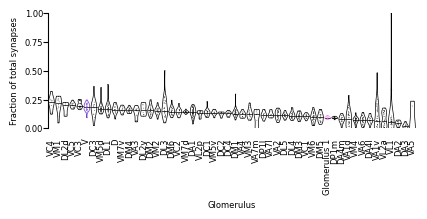

In [24]:
violinplot_dims = (4.75, 1.5)
custom_palette=['black','black','#723BCB','#EE82EE']
fig, ax = plt.subplots(figsize=violinplot_dims)
my_violinplot(ff_synapse_fraction_data_long, x='variable', y='value', hue='color',fill=False,inner='line_quart',
              order=median_order_density, cut=0, scale='width', linewidth=.5, palette=custom_palette,legend=None)
      
ax = sns.stripplot(ff_synapse_fraction_data_long, x='variable',y='value',hue='color', order=median_order_density, size=.5, palette=custom_palette, legend=None)
ax.set_ylabel("Fraction of total synapses", size=6, fontname="Liberation Sans")
ax.set_xlabel('Glomerulus', size=6, fontname="Liberation Sans")
plt.xticks(fontsize=6, fontname="Liberation Sans")
plt.yticks(fontsize=6, fontname="Liberation Sans")
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.tick_params(axis='y', which='both', left=True, right=False,pad=0)
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=True, offset=None, trim=False)

plt.savefig('../svgs/feedforwardDensity_only_glom1_median_order_wide.svg', format="svg")
plt.show()

In [21]:
#Kruskal-Wallis test
stats.kruskal(ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DA4l']['value'], 
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DC1']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DL4']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DL5']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DM3']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DM4']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DP1m']['value'], 
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VA2']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VA4']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VA6']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VA7l']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VC1']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VC2']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VL2a']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VL2p']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VM4']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DM1']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'D']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DA1']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DA2']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DA4m']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DC2']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DL2d']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DL3']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DM2']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DM5']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DM6']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DP1l']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'V']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VA1d']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VA1v']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VA3']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VA5']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VA7m']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VM1']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VM2']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VM3']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VM5d']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VM7d']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VM7v']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'Glomerulus 1']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DA3']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DC4']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DL2v']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VC4']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VM5v']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DC3']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'DL1']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VL1']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VC3']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VC5']['value'],
ff_synapse_fraction_data_long[ff_synapse_fraction_data_long['variable'] == 'VM6']['value'],nan_policy='omit')

KruskalResult(statistic=555.1942058606569, pvalue=7.165302550969281e-86)

In [23]:
#post hoc tests
uncorrected_feedforward_synapse_density_post_hoc_all = sp.posthoc_mannwhitney(ff_synapse_fraction_data_long,val_col='value',group_col='variable')

synapse_density_correction_results_all = statsmodels.stats.multitest.multipletests(uncorrected_feedforward_synapse_density_post_hoc_all['Glomerulus 1'], alpha=0.05, method='bonferroni')
corrected_feedforward_synapse_density_post_hoc_all = pd.DataFrame({'Glomerulus': list(uncorrected_feedforward_synapse_density_post_hoc_all['Glomerulus 1'].index),
                                               'significant': synapse_density_correction_results_all[0],
                                               'uncorrected_p_value': uncorrected_feedforward_synapse_density_post_hoc_all['Glomerulus 1'],
                                               'corrected p_value':synapse_density_correction_results_all[1]})
corrected_feedforward_synapse_density_post_hoc_all

,Glomerulus,significant,uncorrected_p_value,corrected p_value
D,D,True,0.000280,0.014551
DA1,DA1,True,0.000262,0.013613
DA2,DA2,True,0.000036,0.001866
DA3,DA3,True,0.000063,0.003265
DA4l,DA4l,False,0.028953,1.000000
DA4m,DA4m,False,0.093986,1.000000
DC1,DC1,True,0.000047,0.002450
DC2,DC2,False,0.002057,0.106952
DC3,DC3,False,0.001404,0.072991
DC4,DC4,True,0.000491,0.025526
